In [75]:
import numpy as np
import pandas as pd

In [76]:
np.random.seed(42)

Titan Grid

In [77]:
import os
lat = np.arange(-90, 95, 5)
lon = np.arange(0, 365, 5)
grid = [(la, lo) for la in lat for lo in lon]
df = pd.DataFrame(grid, columns=["latitude", "longitude"])
df["surface_temperature"] = (
    94
    - 6 * np.cos(np.radians(df["latitude"]))
    + np.random.normal(0, 0.8, len(df))
).clip(88, 98)
df["surface_pressure"] = (
    1.467
    + np.random.normal(0, 0.005, len(df))
)
df["tholins_index"] = (
    0.3
    + 0.5 * np.exp(-(df["latitude"] / 40) ** 2)
    + np.random.normal(0, 0.03, len(df))
).clip(0.2, 1.0)
df["chemical_energy"] = (
    0.2
    + 0.6 * df["tholins_index"]
    + np.random.normal(0, 0.06, len(df))
).clip(0.1, 1.0)
df["cryovolcanism"] = 0
candidate_regions = [
    (-20, 120),
    (15, 30),
    (40, 200)
]
for lat_c, lon_c in candidate_regions:
    mask = (
        (np.abs(df["latitude"] - lat_c) < 10) &
        (np.abs(df["longitude"] - lon_c) < 10)
    )
    df.loc[mask, "cryovolcanism"] = 1
    df["gravity"] = 1.352
os.makedirs("data", exist_ok=True)
df.to_csv("data/titan_proxy_dataset.csv", index=False)
print("Cassini-faithful proxy dataset generated:", df.shape)

Cassini-faithful proxy dataset generated: (2701, 8)


Surface Temperature (K)

Surface Pressure (bar)

Preprocessing/Grid-Mapping

In [78]:
import pandas as pd

class TitanGridMapper:


    def __init__(self):
        self.required_columns = [
            "latitude",
            "longitude",
            "surface_temperature",
            "surface_pressure",
            "tholins_index",
            "chemical_energy",
            "cryovolcanism",
            "gravity"
        ]

    def load(self, filepath: str) -> pd.DataFrame:

        df = pd.read_csv(filepath)
        return df

    def validate(self, df: pd.DataFrame) -> None:

        missing = set(self.required_columns) - set(df.columns)
        if missing:
            raise ValueError(f"Missing columns: {missing}")

        # Physical sanity checks
        assert df["surface_temperature"].between(80, 110).all()
        assert df["surface_pressure"].between(1.4, 1.6).all()
        assert df["tholins_index"].between(0, 1).all()
        assert df["chemical_energy"].between(0, 1).all()
        assert df["gravity"].nunique() == 1

    def aggregate(self, df: pd.DataFrame) -> pd.DataFrame:

        grouped = (
            df.groupby(["latitude", "longitude"], as_index=False)
            .mean()
        )
        return grouped

    def process(self, filepath: str) -> pd.DataFrame:

        df = self.load(filepath)
        self.validate(df)
        df = self.aggregate(df)
        return df

In [79]:
mapper = TitanGridMapper()
df_clean = mapper.process("data/titan_proxy_dataset.csv")

print(df_clean.shape)
print(df_clean.head())

(2701, 8)
   latitude  longitude  surface_temperature  surface_pressure  tholins_index  \
0       -90          0            94.397371          1.472455       0.319196   
1       -90          5            93.889389          1.477061       0.305898   
2       -90         10            94.518151          1.472119       0.277619   
3       -90         15            95.218424          1.468247       0.303353   
4       -90         20            93.812677          1.472225       0.257219   

   chemical_energy  cryovolcanism  gravity  
0         0.279024            0.0    1.352  
1         0.314094            0.0    1.352  
2         0.247721            0.0    1.352  
3         0.379712            0.0    1.352  
4         0.403457            0.0    1.352  


Feature aka chemical features

In [80]:
# features/chemical_features.py

import pandas as pd

class TitanChemicalFeatures:


    def __init__(self, w_tholins: float = 0.6, w_energy: float = 0.4):

        self.w_tholins = w_tholins
        self.w_energy = w_energy

    def compute(self, df: pd.DataFrame) -> pd.DataFrame:

        df = df.copy()

        df["chemical_potential_score"] = (
            self.w_tholins * df["tholins_index"]
            + self.w_energy * df["chemical_energy"]
        )

        return df


features here bole toh once impacted by temperature

In [81]:
# features/thermal_features.py

import pandas as pd
import numpy as np

class TitanThermalFeatures:


    def __init__(self, optimal_temp: float = 94.0):

        self.optimal_temp = optimal_temp

    def compute(self, df: pd.DataFrame) -> pd.DataFrame:


        df = df.copy()

        # Temperature deviation penalty
        temp_penalty = np.abs(
            df["surface_temperature"] - self.optimal_temp
        )

        # Normalize penalty
        temp_penalty = temp_penalty / temp_penalty.max()

        df["thermal_stability_score"] = (
            1 - temp_penalty
        )

        return df


In [82]:
mapper = TitanGridMapper()
df = mapper.process("data/titan_proxy_dataset.csv")

chem = TitanChemicalFeatures()
therm = TitanThermalFeatures()

df = chem.compute(df)
df = therm.compute(df)

print(df[[
    "chemical_potential_score",
    "thermal_stability_score"
]].describe())

       chemical_potential_score  thermal_stability_score
count               2701.000000              2701.000000
mean                   0.492243                 0.388044
std                    0.151827                 0.312618
min                    0.229007                 0.000000
25%                    0.360436                 0.110523
50%                    0.445644                 0.322600
75%                    0.629737                 0.658278
max                    0.845542                 0.999714


Feature Matrix

In [83]:
feature_cols = [
    "chemical_potential_score",
    "thermal_stability_score",
    "cryovolcanism"
]

X = df[feature_cols]

Robust Scaling

In [84]:
import pandas as pd
from sklearn.preprocessing import RobustScaler

class TitanNormalizer:
    def __init__(self):
        self.scaler = RobustScaler()

    def fit_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_scaled = self.scaler.fit_transform(X)
        return pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_scaled = self.scaler.transform(X)
        return pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

normalizer = TitanNormalizer()
X_scaled = normalizer.fit_transform(X)

In [85]:
import pandas as pd
from sklearn.decomposition import PCA

class TitanPCA:
    def __init__(self, variance_threshold: float = 0.9):
        self.variance_threshold = variance_threshold
        self.pca = None
        self.n_components_ = 0
        self.explained_variance_ratio = None

    def fit(self, X: pd.DataFrame) -> None:
        # Fit PCA to determine number of components based on variance_threshold
        pca_full = PCA()
        pca_full.fit(X)

        cumulative_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)
        self.n_components_ = np.where(cumulative_variance_ratio >= self.variance_threshold)[0][0] + 1

        self.pca = PCA(n_components=self.n_components_)
        self.pca.fit(X)
        self.explained_variance_ratio = self.pca.explained_variance_ratio_

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.pca is None:
            raise RuntimeError("PCA model not fitted. Call .fit() first.")
        return pd.DataFrame(self.pca.transform(X), index=X.index)

    def explained_variance(self) -> np.ndarray:
        if self.pca is None:
            raise RuntimeError("PCA model not fitted. Call .fit() first.")
        return self.pca.explained_variance_ratio_

    def loadings(self, feature_names: list) -> pd.DataFrame:
        if self.pca is None:
            raise RuntimeError("PCA model not fitted. Call .fit() first.")
        # Loadings are the components, representing the correlation between original features and PCs
        return pd.DataFrame(self.pca.components_.T, index=feature_names, columns=[f'PC{i+1}' for i in range(self.n_components_)])


pca_model = TitanPCA(variance_threshold=0.9)
pca_model.fit(X_scaled)

X_pca = pca_model.transform(X_scaled)

print(pca_model.explained_variance())
print(pca_model.loadings(feature_cols))

[0.89429885 0.09066477]
                               PC1       PC2
chemical_potential_score -0.701738  0.712376
thermal_stability_score   0.712345  0.701796
cryovolcanism            -0.011344  0.001781


In [86]:
import pandas as pd
import numpy as np

def dbscan_parameter_sweep(
    X_pca: pd.DataFrame,
    eps_values: list,
    min_samples: int = 8
):
    """
    Sweeps DBSCAN eps values and prints cluster statistics.
    """
    results = []

    for eps in eps_values:
        db = TitanDBSCAN(eps=eps, min_samples=min_samples)
        clusters = db.fit_predict(X_pca)

        unique, counts = np.unique(clusters, return_counts=True)
        cluster_info = dict(zip(unique, counts))

        n_clusters = len(unique) - (1 if -1 in unique else 0)
        n_outliers = cluster_info.get(-1, 0)

        results.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "n_outliers": n_outliers
        })

        print(
            f"eps={eps:.2f} | clusters={n_clusters} | outliers={n_outliers}"
        )

    return pd.DataFrame(results)


In [87]:
eps_values = [0.20, 0.15, 0.12, 0.10, 0.08, 0.06, 0.05]

sweep_results = dbscan_parameter_sweep(
    X_pca,
    eps_values=eps_values,
    min_samples=10
)

sweep_results


eps=0.20 | clusters=1 | outliers=1
eps=0.15 | clusters=1 | outliers=8
eps=0.12 | clusters=1 | outliers=17
eps=0.10 | clusters=1 | outliers=34
eps=0.08 | clusters=1 | outliers=65
eps=0.06 | clusters=1 | outliers=202
eps=0.05 | clusters=7 | outliers=324


,eps,min_samples,n_clusters,n_outliers
0,0.20,10,1,1
1,0.15,10,1,8
2,0.12,10,1,17
3,0.10,10,1,34
4,0.08,10,1,65
5,0.06,10,1,202
6,0.05,10,7,324


In [88]:
dbscan = TitanDBSCAN(eps=0.08, min_samples=10)
clusters = dbscan.fit_predict(X_pca)

print(dbscan.summary(clusters))


  Cluster ID Number of Points
0         -1               65
1          0             2636


In [89]:
X_pca.assign(cluster=clusters).groupby("cluster").mean()


,0,1
cluster,,
-1,-0.056104,0.106404
0,0.001383,-0.002624


THI Computation

In [90]:
import pandas as pd
import numpy as np

class TitanHabitabilityIndex:
    """
    Computes Titan Habitability Index (THI)
    using PCA-space magnitude (robust to zero-centering).
    """

    def __init__(self, explained_variance: pd.Series):
        self.weights = explained_variance / explained_variance.sum()

    def compute_point_thi(self, df_pca: pd.DataFrame) -> pd.Series:
        weighted = df_pca.mul(self.weights, axis=1)
        return np.sqrt((weighted ** 2).sum(axis=1))

    def compute_cluster_thi(
        self,
        df_pca: pd.DataFrame,
        clusters: pd.Series
    ) -> pd.DataFrame:
        df = df_pca.copy()
        df["cluster"] = clusters

        # Drop outliers
        df = df[df["cluster"] != -1]

        df["THI_point"] = self.compute_point_thi(
            df.drop(columns="cluster")
        )

        return (
            df.groupby("cluster")["THI_point"]
            .mean()
            .rename("THI_cluster")
            .sort_values(ascending=False)
            .reset_index()
        )


In [91]:
thi_model = TitanHabitabilityIndex(pca_model.explained_variance())

cluster_thi = thi_model.compute_cluster_thi(
    X_pca,
    clusters
)

print(cluster_thi)


   cluster  THI_cluster
0        0     0.615606


In [92]:
df_results = df.copy()
df_results["cluster"] = clusters

df_results = df_results.merge(
    cluster_thi,
    on="cluster",
    how="left"
)

df_results.head()


,latitude,longitude,surface_temperature,surface_pressure,tholins_index,chemical_energy,cryovolcanism,gravity,chemical_potential_score,thermal_stability_score,cluster,THI_cluster
0,-90,0,94.397371,1.472455,0.319196,0.279024,0.0,1.352,0.303127,0.933771,0,0.615606
1,-90,5,93.889389,1.477061,0.305898,0.314094,0.0,1.352,0.309176,0.981565,0,0.615606
2,-90,10,94.518151,1.472119,0.277619,0.247721,0.0,1.352,0.265660,0.913642,0,0.615606
3,-90,15,95.218424,1.468247,0.303353,0.379712,0.0,1.352,0.333897,0.796929,0,0.615606
4,-90,20,93.812677,1.472225,0.257219,0.403457,0.0,1.352,0.315714,0.968780,0,0.615606


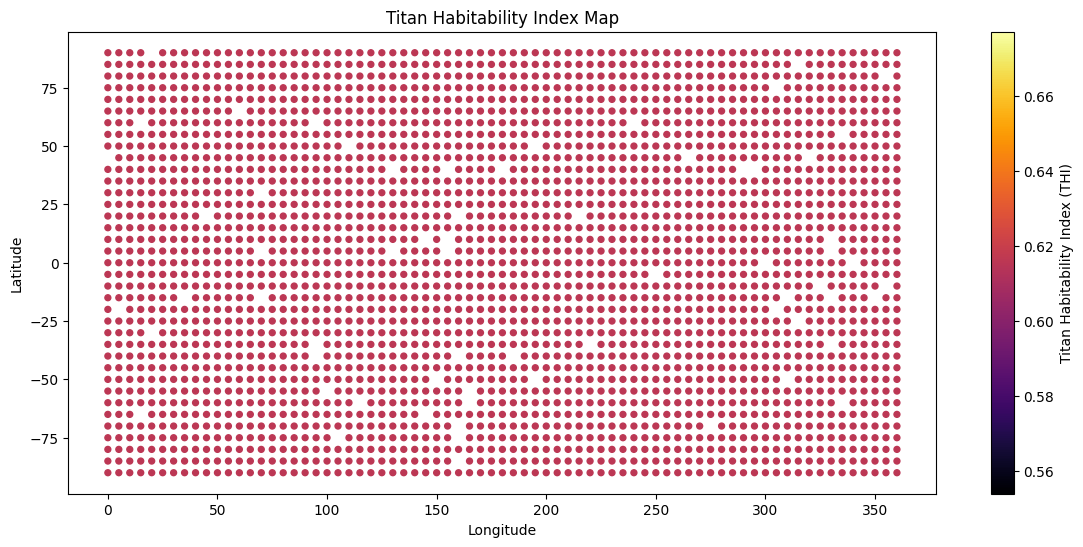

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
sc = plt.scatter(
    df_results["longitude"],
    df_results["latitude"],
    c=df_results["THI_cluster"],
    cmap="inferno",
    s=18
)
plt.colorbar(sc, label="Titan Habitability Index (THI)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Titan Habitability Index Map")
plt.show()


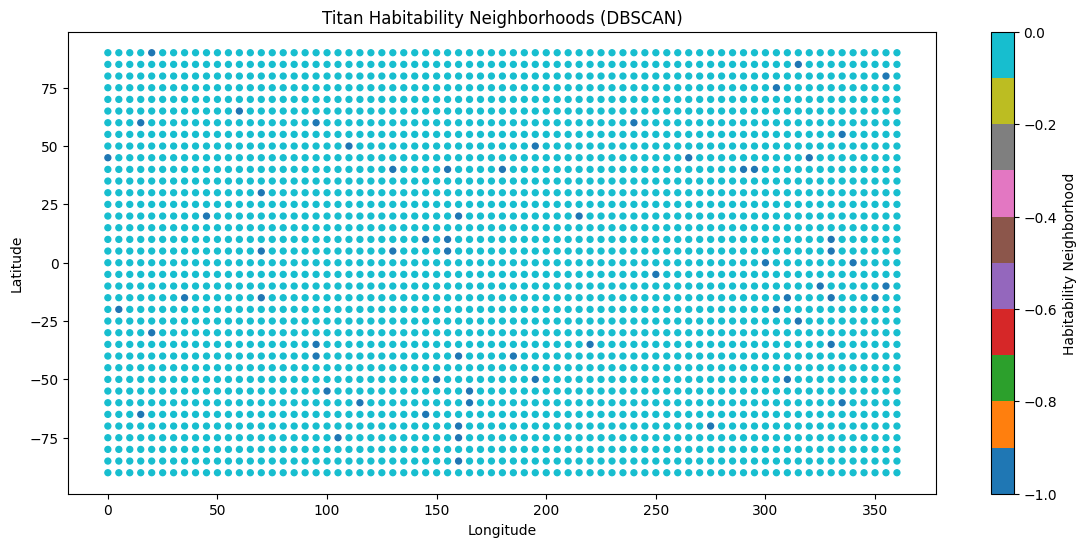

In [94]:
plt.figure(figsize=(14,6))
sc = plt.scatter(
    df_results["longitude"],
    df_results["latitude"],
    c=df_results["cluster"],
    cmap="tab10",
    s=18
)
plt.colorbar(sc, label="Habitability Neighborhood")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Titan Habitability Neighborhoods (DBSCAN)")
plt.show()


In [95]:
import pandas as pd
import numpy as np

class TitanSensitivityAnalysis:
    def __init__(
        self,
        normalizer,
        pca_model,
        thi_model
    ):
        self.normalizer = normalizer
        self.pca_model = pca_model
        self.thi_model = thi_model

    def run(self, original_df, clusters, perturbation_strength=0.01):
        results = []
        feature_cols = original_df.columns

        for col in feature_cols:

            perturbed_df = original_df.copy()
            perturbed_df[col] = perturbed_df[col] * (1 + perturbation_strength)


            perturbed_scaled = self.normalizer.transform(perturbed_df)


            perturbed_pca = self.pca_model.transform(perturbed_scaled)


            perturbed_cluster_thi = self.thi_model.compute_cluster_thi(
                perturbed_pca,
                clusters
            )

            # Assuming 'cluster' 0 is the primary cluster to evaluate for simplicity

            original_thi_cluster_0 = self.thi_model.compute_cluster_thi(self.pca_model.transform(self.normalizer.transform(original_df)), clusters)
            original_thi_value = original_thi_cluster_0.loc[original_thi_cluster_0['cluster'] == 0, 'THI_cluster'].iloc[0]

            perturbed_thi_value = perturbed_cluster_thi.loc[perturbed_cluster_thi['cluster'] == 0, 'THI_cluster'].iloc[0]

            change = perturbed_thi_value - original_thi_value
            percentage_change = (change / original_thi_value) * 100 if original_thi_value != 0 else np.nan

            results.append({
                'feature': col,
                'original_THI_cluster_0': original_thi_value,
                'perturbed_THI_cluster_0': perturbed_thi_value,
                'change': change,
                'percentage_change': percentage_change
            })

        return pd.DataFrame(results)

sensitivity = TitanSensitivityAnalysis(
    normalizer=normalizer,
    pca_model=pca_model,
    thi_model=thi_model
)

sensitivity_results = sensitivity.run(
    df[feature_cols],
    clusters
)

print(sensitivity_results)

                    feature  original_THI_cluster_0  perturbed_THI_cluster_0  \
0  chemical_potential_score                0.615606                 0.618602   
1   thermal_stability_score                0.615606                 0.618734   
2             cryovolcanism                0.615606                 0.615607   

         change  percentage_change  
0  2.996105e-03           0.486692  
1  3.128149e-03           0.508141  
2  9.750792e-07           0.000158  
